In this notebook, we will implement an Alternating Least Squares (ALS) algorithm and predict the ratings for the movies in [MovieLens small dataset](https://grouplens.org/datasets/movielens/latest/)

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import os
import time
%matplotlib inline

## Data ETL and Data Exploration

In [0]:
movies = pd.read_csv("ml-latest-small/movies.csv")
ratings = pd.read_csv("ml-latest-small/ratings.csv")
links = pd.read_csv("ml-latest-small/links.csv")
tags = pd.read_csv("ml-latest-small/tags.csv")

In [0]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [0]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [0]:
print 'Distinct values of ratings:'
print sorted(ratings.rating.unique())

Distinct values of ratings:
[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


In [0]:
print 'For the users that rated movies and the movies that were rated:'
print 'Minimum number of ratings per user is', ratings.userId.value_counts().min()
print 'Minimum number of ratings per movie is', ratings.movieId.value_counts().min()

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1


In [0]:
print '{} out of {} movies are rated by only one user'.format(sum(ratings.movieId.value_counts() == 1), \
                                                              len(ratings.movieId.unique()))

3063 out of 9066 movies are rated by only one user


In [0]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [0]:
tags.head()

,userId,movieId,tag,timestamp
0,15,339,sandra 'boring' bullock,1138537770
1,15,1955,dentist,1193435061
2,15,7478,Cambodia,1170560997
3,15,32892,Russian,1170626366
4,15,34162,forgettable,1141391765


### Q1: The number of Users

In [0]:
num_users = np.union1d(ratings['userId'], tags['userId']).shape[0]
num_users

671

### Q2: The number of Movies

In [0]:
np.union1d(ratings['movieId'], tags['movieId']).shape[0]

9125

### Q3:  How many movies are rated by users? List movies not rated before

In [0]:
num_movies_rated = ratings['movieId'].unique().shape[0]
num_movies_rated

9066

In [0]:
all_movies = np.union1d(ratings['movieId'], tags['movieId'])
rated = ratings['movieId'].unique()
not_rated = [x for x in all_movies if x not in rated]

# showing 20 examples only
pd.DataFrame(not_rated, columns = ['movieId']).head(20)

,movieId
0,4712
1,4763
2,5169
3,5289
4,5984
5,6229
6,6515
7,6683
8,6830
9,7243


### Q4: List Movie Genres

In [0]:
# showing 20 examples only
pd.DataFrame(movies['genres'].unique(), columns = ['genres']).head(20)

,genres
0,Adventure|Animation|Children|Comedy|Fantasy
1,Adventure|Children|Fantasy
2,Comedy|Romance
3,Comedy|Drama|Romance
4,Comedy
5,Action|Crime|Thriller
6,Adventure|Children
7,Action
8,Action|Adventure|Thriller
9,Comedy|Horror


### Q5: Movie for Each Category

In [0]:
# showing top 20 only
movies["genres"].value_counts().head(20) 

Drama                    1170
Comedy                    809
Comedy|Drama              425
Documentary               365
Drama|Romance             356
Comedy|Romance            341
Comedy|Drama|Romance      264
Horror                    183
Drama|Thriller            172
Crime|Drama               135
Crime|Drama|Thriller      116
Horror|Thriller           112
Drama|War                 107
Comedy|Crime               77
Thriller                   74
Action|Comedy              67
Children|Comedy            64
Action|Thriller            57
Comedy|Horror              57
Action|Crime|Thriller      53
Name: genres, dtype: int64

## Prepare Data for Training

In [0]:
rating_data = ratings.drop(['timestamp'], axis = 1)

In [0]:
rating_data.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


We will use a `num_users` x `num_movies_rated` matrix to represent the ratings, in which zeros are the user-movie pairs without a rating.

In [0]:
ratings_matrix = np.zeros((num_users, num_movies_rated))

usersId = np.sort(ratings.userId.unique())
moviesId = np.sort(ratings.movieId.unique())

for i in range(len(rating_data)):
    user = rating_data.iloc[i, 0]
    movie = rating_data.iloc[i, 1]
    ratings_matrix[usersId == user, moviesId == movie] = rating_data.iloc[i, 2]
    
ratings_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.]])

Now we split the data into training/validation/testing sets using a 6/2/2 ratio. We use a for loop to split the existing ratings for each user. Because the minimum number of ratings per user is 20, each user will have at least 12, 4, and 4 ratings in the training, validation, and testing sets, respectively.

In [0]:
import random
random.seed(0)

def data_split(ratings, ratio):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in xrange(ratings.shape[0]):
        index = ratings[user, :].nonzero()[0]
        k = int(round(len(index) * ratio))
        test_ratings = random.sample(index, k)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    return train, test

In [0]:
train_matrix, tmp = data_split(ratings_matrix, 0.4)
validation_matrix, test_matrix = data_split(tmp, 0.5)

In [0]:
print 'Number of ratings in the training set:', (train_matrix > 0).sum()
print 'Number of ratings in the validation set:', (validation_matrix > 0).sum()
print 'Number of ratings in the testing set:', (test_matrix > 0).sum()

Number of ratings in the training set: 60012
Number of ratings in the validation set: 19873
Number of ratings in the testing set: 20119


## ALS Model
Now we’ll build a ALS model. The implementation below is borrowed and modified from [here](https://blog.insightdatascience.com/explicit-matrix-factorization-als-sgd-and-all-that-jazz-b00e4d9b21ea). One main modification is that we train the model with the mean subtracted ratings here. At the prediction step, the mean rating will be added back. This approach makes it easier for the model to converge.

In [0]:
from numpy.linalg import solve

class ALS(object):
    
    def __init__(self, ratings, n_factors=10, reg=0.0, verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        
        reg : (float)
            Regularization term for both user and item latent factors
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        # we will train the model with the mean subtracted ratings, and 
        # at the prediction step, the mean will be added back. 
        self.raw_ratings = ratings
        self.mean = ratings[ratings > 0].mean()
        self.ratings = ratings.copy() 
        self.ratings[ratings > 0] = self.ratings[ratings > 0] - self.mean
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.reg = reg
        self._v = verbose

    def als_step(self, latent_vectors, fixed_vecs, ratings, _lambda, type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute for the item latent vectors
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in xrange(latent_vectors.shape[0]):
                #latent_vectors[u, :] = (solve((YTY + lambdaI).T, (ratings[u, :].dot(fixed_vecs)).T)).T
                latent_vectors[u, :] = solve((YTY + lambdaI), ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute for the user latent vectors
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in xrange(latent_vectors.shape[0]):
                #latent_vectors[i, :] = (solve((XTX + lambdaI).T, (ratings[:, i].T.dot(fixed_vecs)).T)).T
                latent_vectors[i, :] = solve((XTX + lambdaI), ratings[:, i].T.dot(fixed_vecs))

        return latent_vectors

    def train(self, n_iter=10):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors using a normal distribution centered at 0
        self.user_vecs = np.random.normal(0,1,(self.n_users, self.n_factors)) 
        self.item_vecs = np.random.normal(0,1,(self.n_items, self.n_factors)) 
       
        self.partial_train(n_iter)
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        count = 1
        while count <= n_iter:
            if count % 10 == 0 and self._v:
                print '\tcurrent iteration: {}'.format(count)
            self.user_vecs = self.als_step(self.user_vecs, 
                                           self.item_vecs, 
                                           self.ratings, 
                                           self.reg, 
                                           type='user')
            self.item_vecs = self.als_step(self.item_vecs, 
                                           self.user_vecs, 
                                           self.ratings, 
                                           self.reg, 
                                           type='item')
            count += 1
    
    def predict_all(self):
        """ Predict ratings for every user and item. """
        predictions = self.user_vecs.dot(self.item_vecs.T) + self.mean        
        return predictions
    
    def calculate_learning_curve(self, iter_array, valid):
        """
        Keep track of RMSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        valid : (2D ndarray)
            Validation dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_rmse : (list)
            Training data RMSE values for each value of iter_array
        valid_rmse : (list)
            Validation data RMSE values for each value of iter_array
        """
        self.iter_array = iter_array
        self.iter_array.sort()
        self.train_rmse =[]
        self.valid_rmse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(self.iter_array):
            if self._v:
                print 'Iteration: {}'.format(n_iter)
            if i == 0:
                self.train(n_iter - iter_diff)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_rmse += [get_rmse(predictions, self.raw_ratings)]
            self.valid_rmse += [get_rmse(predictions, valid)]
            if self._v:
                print 'Train RMSE: ' + str(self.train_rmse[-1])
                print 'Validation RMSE: ' + str(self.valid_rmse[-1])
            iter_diff = n_iter

    def plot_learning_curve(self):
        """ Plot the learning curves """
        plt.plot(self.iter_array, self.train_rmse, label='Training', linewidth=5)
        plt.plot(self.iter_array, self.valid_rmse, label='Validation', linewidth=5)
        plt.xticks(range(0, max(self.iter_array) + 1, 2), fontsize=16)
        plt.yticks(fontsize=16)
        plt.xlabel('iterations', fontsize=30)
        plt.ylabel('RMSE', fontsize=30)
        plt.legend(loc='best', fontsize=20) 
        plt.show()

        
def get_rmse(predictions, ratings):
    """ Calculate RMSE for predicted ratings"""
    diff = (predictions - ratings)[ratings > 0]
    return np.sqrt((diff**2).mean())

## Model Selection and Evaluation
With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [0]:
latent_factors = [6, 8, 10, 12, 14]
regularizations = [0.05, 0.1, 0.2, 0.4, 0.8]

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['valid_rmse'] = np.inf
best_params['model'] = None

start_time = time.time()

for fact in latent_factors:
    for reg in regularizations:
        als = ALS(train_matrix, n_factors=fact, reg=reg)
        als.train(n_iter = 10)
        predict_all = als.predict_all()
        rmse = get_rmse(predict_all, validation_matrix)
        rmse_train = get_rmse(predict_all, train_matrix)
        print '{} latent factors and regularization = {}: validation RMSE is {}'.format(fact, reg, rmse)
        if rmse < best_params['valid_rmse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['valid_rmse'] = rmse
            best_params['model'] = als

print '\nThe best model has {} latent factors and regularization = {}'.format(\
        best_params['n_factors'], best_params['reg'])        
print 'Total Runtime: {:.2f} seconds'.format(time.time() - start_time)

6 latent factors and regularization = 0.05: validation RMSE is 1.03075644988
6 latent factors and regularization = 0.1: validation RMSE is 1.03078324654
6 latent factors and regularization = 0.2: validation RMSE is 1.03071943567
6 latent factors and regularization = 0.4: validation RMSE is 1.03079891177
6 latent factors and regularization = 0.8: validation RMSE is 1.03102107355
8 latent factors and regularization = 0.05: validation RMSE is 1.03035199462
8 latent factors and regularization = 0.1: validation RMSE is 1.03005616187
8 latent factors and regularization = 0.2: validation RMSE is 1.0290996407
8 latent factors and regularization = 0.4: validation RMSE is 1.02952589138
8 latent factors and regularization = 0.8: validation RMSE is 1.0307111632
10 latent factors and regularization = 0.05: validation RMSE is 1.03058856747
10 latent factors and regularization = 0.1: validation RMSE is 1.02977065267
10 latent factors and regularization = 0.2: validation RMSE is 1.0293384174
10 latent

The model with 10 latent factors and lambda = 0.4 yields the best result. Let's plot the learning curves for this model.

In [0]:
best_model = best_params['model']
iter_array = [1, 2, 5, 10]

In [0]:
best_model.calculate_learning_curve(iter_array, validation_matrix)

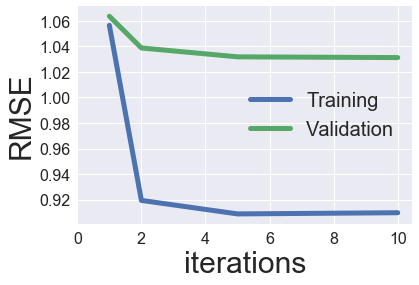

In [0]:
best_model.plot_learning_curve()

And finally, let's check the testing error.

In [0]:
print 'For testing data the RMSE is {}'.format(get_rmse(best_model.predict_all(), test_matrix))

For testing data the RMSE is 1.0233150573


This is consistent with our validation error.